# Match data based on study date

In [1]:
import os
import pandas as pd
from ipywidgets import interact, fixed
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import re
from glob import glob
from datetime import datetime
from pydicom import read_file
from tqdm import tqdm_notebook as tqdm
import imageio



In [2]:
clean_data_dir = '/storage/groups/ml01/datasets/projects/20181610_eyeclinic_niklas.koehler/dwh_tables_cleaned'


In [68]:
octs = pd.read_csv(os.path.join(clean_data_dir, 'octs_fundus_no_dups.csv'), index_col=0)
octs.study_date = pd.to_datetime(octs.study_date)

visus = pd.read_csv(os.path.join(clean_data_dir, 'visus_labels_clean.csv'), index_col=0)
visus.study_date = pd.to_datetime(visus.study_date)

thickness = pd.read_csv(os.path.join(clean_data_dir, 'thickness_maps_no_dups.csv'), index_col=0)
thickness.study_date = pd.to_datetime(thickness.study_date)

injections = pd.read_csv(os.path.join(clean_data_dir, 'injections_clean.csv'), index_col=0)
injections.study_date = pd.to_datetime(injections.study_date)

diagnosis = pd.read_csv(os.path.join(clean_data_dir, 'diagnosis_longitudinal_clean.csv'), index_col=0)
diagnosis.iol_date = pd.to_datetime(diagnosis.iol_date)

## Match OCTs, visus, thickness 
- OCTs and thickness based on study date
- visus and OCTs on same date (NEVER after injection)

In [69]:
print('Merging {} octs with {} thickness maps'.format(len(octs), len(thickness)))
merged = pd.merge(octs, thickness, on=['patient_id', 'laterality', 'study_date'], how='left')
print('Result: {} oct/thickness pairs'.format(len(merged.dropna(subset=['thickness_path']))))

print('Merging {} octs with {} visus labels'.format(len(merged), len(visus)))
merged = pd.merge(merged, visus, on=['patient_id', 'laterality', 'study_date'], how='outer') # keep all visus labels
print('Result: {} oct/visus pairs'.format(len(merged.dropna(subset=['oct_path', 'visual_acuity']))))

#print('Merging {} octs with {} injections'.format(len(merged), len(injections)))
#merged = pd.merge(merged, injections, on=['study_date', 'patient_id', 'laterality'], how='outer') # keep all injections
#print('Result: {} oct/visus/injections pairs'.format(len(merged.dropna(subset=['oct_path', 'visual_acuity', 'MED']))))

Merging 127279 octs with 114543 thickness maps
Result: 113922 oct/thickness pairs
Merging 127279 octs with 618989 visus labels
Result: 108665 oct/visus pairs


In [71]:
# make results columns nice
merged.loc[:,'oct?'] = ~merged['oct_path'].isna()
merged.loc[:,'visus?'] = ~merged['logMAR'].isna()
merged.loc[:,'thickness?'] = ~merged['thickness_path'].isna()
merged.loc[:,'fundus?'] = ~merged['fundus_path'].isna()

oct_measurements = merged.copy()
# clean up merged table
oct_measurements = oct_measurements.drop(columns=['visual_acuity_raw', 'logMAR_raw', 'laterality_raw', 'visual_acuity_origin'])

In [72]:
disp_cols = ['patient_id', 'laterality', 'study_date', 'oct?', 'visus?', 'thickness?', 'fundus?']
oct_measurements[disp_cols]

,patient_id,laterality,study_date,oct?,visus?,thickness?,fundus?
0,363979,R,2018-01-29,True,True,True,True
1,363979,L,2018-01-29,True,True,True,True
2,350569,R,2017-03-06,True,True,True,True
3,350569,L,2017-03-06,True,True,True,True
4,185669,L,2014-12-09,True,True,False,True
...,...,...,...,...,...,...,...
637598,376148,R,2018-09-23,False,True,False,False
637599,376148,R,2018-09-25,False,True,False,False
637600,376148,R,2018-10-01,False,True,False,False
637601,376150,L,2018-11-23,False,True,False,False


## Prepare data for LSTM

### Limit oct measurements to longitudinal patients, add diagnosis

In [73]:
# merge diagnosis label to each patient instance (laterality + study date)
longitudinal_data = pd.merge(oct_measurements, diagnosis[['patient_id', 'laterality', 'diagnosis_raw', 'diagnosis']], on=['patient_id', 'laterality'], how='inner')

In [74]:
longitudinal_data

,patient_id,laterality,study_date,oct_path,fundus_path,thickness_path,visual_acuity,logMAR,oct?,visus?,thickness?,fundus?,diagnosis_raw,diagnosis
0,34537,R,2014-12-16,/storage/groups/ml01/datasets/raw/2018_LMUAuge...,/storage/groups/ml01/datasets/raw/2018_LMUAuge...,/storage/groups/ml01/datasets/projects/2018161...,0.2,0.698970,True,True,True,True,Irvine-Gass-Syndrom,NaN
1,34537,R,2016-01-26,/storage/groups/ml01/datasets/raw/2018_LMUAuge...,/storage/groups/ml01/datasets/raw/2018_LMUAuge...,/storage/groups/ml01/datasets/projects/2018161...,0.25,0.602060,True,True,True,True,Irvine-Gass-Syndrom,NaN
2,34537,R,2017-12-13,/storage/groups/ml01/datasets/raw/2018_LMUAuge...,/storage/groups/ml01/datasets/raw/2018_LMUAuge...,/storage/groups/ml01/datasets/projects/2018161...,0.25,0.602060,True,True,True,True,Irvine-Gass-Syndrom,NaN
3,34537,R,2014-09-16,/storage/groups/ml01/datasets/raw/2018_LMUAuge...,/storage/groups/ml01/datasets/raw/2018_LMUAuge...,/storage/groups/ml01/datasets/projects/2018161...,0.32,0.494850,True,True,True,True,Irvine-Gass-Syndrom,NaN
4,34537,R,2013-11-05,/storage/groups/ml01/datasets/raw/2018_LMUAuge...,/storage/groups/ml01/datasets/raw/2018_LMUAuge...,/storage/groups/ml01/datasets/projects/2018161...,NaN,NaN,True,False,True,True,Irvine-Gass-Syndrom,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42873,290507,R,2013-05-27,NaN,NaN,NaN,0.05,1.301030,False,True,False,False,AMD,AMD
42874,290507,R,2013-06-25,NaN,NaN,NaN,0.05,1.301030,False,True,False,False,AMD,AMD
42875,290507,R,2013-07-23,NaN,NaN,NaN,0.05,1.301030,False,True,False,False,AMD,AMD
42876,290507,R,2014-04-10,NaN,NaN,NaN,0.02857142857142857,1.544068,False,True,False,False,AMD,AMD


### Create events table with injections and surgery dates

In [76]:
longitudinal_patients = diagnosis[['patient_id', 'laterality']].drop_duplicates(['patient_id', 'laterality'])

# add injections
events = pd.merge(longitudinal_patients, injections[['patient_id', 'laterality', 'study_date', 'MED']], on=['patient_id', 'laterality'], how='inner')
events.loc[:,'injection?'] = ~events['MED'].isna()

# add lens surgery data
lens_surgery = diagnosis[['patient_id', 'laterality', 'iol_date']].copy()
lens_surgery.rename(columns={'iol_date': 'study_date'}, inplace=True)
lens_surgery['iol?'] = ~lens_surgery.study_date.isna()
lens_surgery = lens_surgery[lens_surgery['iol?']]
# limit to longitudinal data
lens_surgery = pd.merge(longitudinal_patients, lens_surgery, on=['patient_id', 'laterality'], how='inner')
# add to events
events = pd.concat([events, lens_surgery], ignore_index=True)

/home/icb/hannah.spitzer/miniconda3/envs/lode/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  from ipykernel import kernelapp as app


In [77]:
events

,MED,injection?,iol?,laterality,patient_id,study_date
0,Lucentis,True,NaN,L,1557,2014-10-20
1,Lucentis,True,NaN,L,1557,2014-11-10
2,Lucentis,True,NaN,L,1557,2014-12-10
3,Lucentis,True,NaN,L,3351,2014-01-31
4,Lucentis,True,NaN,L,3351,2014-03-07
...,...,...,...,...,...,...
4646,NaN,NaN,True,R,357757,2017-08-16
4647,NaN,NaN,True,R,358308,2017-08-28
4648,NaN,NaN,True,R,358833,2017-09-11
4649,NaN,NaN,True,R,358904,2017-09-13


### Statistics of available OCTs with visus labels and AMD

In [82]:
# exclude NaN entries
print('Starting with {} entries'.format(len(longitudinal_data)))
filtered = longitudinal_data.dropna(subset=['diagnosis', 'oct_path', 'logMAR'])
print('Non-nan entries: {}'.format(len(filtered)))
amd_patients = filtered[filtered.diagnosis == 'AMD']
dr_patients = filtered[filtered.diagnosis == 'DR']
print('{} amd and {} dr entries remaining'.format(len(amd_patients), len(dr_patients)))

Starting with 42878 entries
Non-nan entries: 18568
15318 amd and 3250 dr entries remaining


# TODO continue here

In [71]:
# move to patient/laterality time-series view
grouped = filtered.groupby(['patient_id', 'laterality'])
# drop all groups that do not have at least one OCT
filtered = grouped.filter(lambda x: x.oct_path.count()>0)
grouped = filtered.groupby(['patient_id', 'laterality'])

In [25]:
# get statistics over lengths of timeseries
num_octs = np.array(grouped.agg({'oct?':'count'})['oct?'])

bins = [1,2,5,10,30,50]
vals, _ = np.histogram(num_octs, bins)
print(vals)

[ 69 174 198 467 133]


In [33]:
    
unique, counts = np.unique(num_octs, return_counts=True)

In [38]:
# calculate how many LSTM samples could make from this data
# assume simple case that want to predict last OCT in series of n previous octs 
# (allow either reusing sequences for new samples or not)
n = 4
reuse_sequences=True

mask = unique >= n+1
c = counts[mask]
u = unique[mask]
res = sum(c)
if reuse_sequences:
    u = unique[mask] - n
    res = sum(c*u)
print(res)


11541


In [31]:
len(grouped.groups)

1049

In [29]:
grouped.agg({'oct?':'count'})

oct?
patient_id laterality      
502        L             10
           R             11
516        L             13
           R             13
709        L             24
...                     ...
360334     R              6
365435     L              8
           R             10
365484     L              6
           R              6

[1049 rows x 1 columns]

In [26]:
sum(vals)

1041

(array([108.,  66.,  39.,  39.,  41.,  34.,  87.,  41.,  47.,  28.,  35.,
         32.,  52.,  22.,   9.,  16.,  10.,  10.,  37.,  18.,  22.,  16.,
         20.,  10.,  16.,  29.,  11.,   5.,  10.,   6.,  10.,  13.,   6.,
          1.,   2.,   4.,   3.,   9.,   1.,   2.,   4.,   1.,   1.,   4.,
          1.,   0.,   0.,   0.,   0.,   2.]),
 array([ 2.  ,  3.16,  4.32,  5.48,  6.64,  7.8 ,  8.96, 10.12, 11.28,
        12.44, 13.6 , 14.76, 15.92, 17.08, 18.24, 19.4 , 20.56, 21.72,
        22.88, 24.04, 25.2 , 26.36, 27.52, 28.68, 29.84, 31.  , 32.16,
        33.32, 34.48, 35.64, 36.8 , 37.96, 39.12, 40.28, 41.44, 42.6 ,
        43.76, 44.92, 46.08, 47.24, 48.4 , 49.56, 50.72, 51.88, 53.04,
        54.2 , 55.36, 56.52, 57.68, 58.84, 60.  ]),
 <a list of 50 Patch objects>)

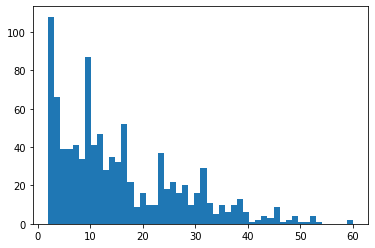

In [27]:


plt.hist(num_octs[num_octs>1], bins=50)

### get only entries with VA measures

In [127]:
len(filtered)

248524

In [93]:
# get all groups with at least one MED
filtered = grouped.filter(lambda x: x.MED.count()>0)
filtered = filtered.sort_values('study_date')
grouped = filtered.groupby(['patient_id', 'laterality'])

In [73]:
i = 0
for name, group in grouped:
    print(name)
    display(group[['study_date', 'oct?', 'visus?','injection?', 'iol?']])
    i+=1
    if i == 10: break

(502, 'L')


,study_date,oct?,visus?,injection?,iol?
32385,2017-05-23,True,True,False,False
32386,2018-01-16,True,True,False,False
32387,2018-07-03,True,True,False,False
32388,2016-08-01,True,True,False,False
32389,2016-09-06,True,True,False,False
32390,2017-08-29,True,True,False,False
32391,2018-04-10,True,True,False,False
32392,2016-04-04,True,True,False,True
32393,2017-07-04,True,True,False,False
32394,2017-10-24,True,True,False,False


(502, 'R')


,study_date,oct?,visus?,injection?,iol?
32402,2017-05-23,True,True,False,False
32403,2016-08-01,True,True,False,False
32404,2016-09-06,True,True,False,False
32405,2018-01-16,True,True,False,False
32406,2018-07-03,True,True,False,False
32407,2016-04-04,True,True,False,True
32408,2017-07-04,True,True,False,False
32409,2017-10-24,True,True,False,False
32410,2018-04-10,True,True,False,False
32419,2015-01-27,False,False,True,False


(516, 'L')


,study_date,oct?,visus?,injection?,iol?
37791,2017-11-07,True,True,False,False
37792,2016-06-06,True,True,False,False
37793,2016-11-29,True,True,False,False
37794,2017-07-19,True,True,False,False
37795,2016-09-20,True,True,False,False
37796,2017-06-07,True,True,False,False
37797,2016-01-18,True,True,False,False
37798,2016-04-04,True,True,False,False
37799,2017-04-26,True,True,False,False
37800,2016-05-04,True,True,False,False


(516, 'R')


,study_date,oct?,visus?,injection?,iol?
37807,2016-10-18,True,True,False,False
37808,2016-05-04,True,True,False,False
37809,2015-09-21,True,True,False,True
37810,2016-07-21,True,True,False,False
37811,2016-01-18,True,True,False,False
37812,2017-04-26,True,True,False,False
37813,2016-04-04,True,True,False,False
37814,2016-09-20,True,True,False,False
37815,2017-07-19,True,True,False,False
37816,2017-06-07,True,True,False,False


(709, 'L')


,study_date,oct?,visus?,injection?,iol?
1504,2016-08-08,True,True,False,False
1505,2017-07-04,True,True,False,False
1506,2018-08-23,True,True,False,False
1507,2015-11-25,True,True,False,False
1508,2017-10-11,True,True,False,False
1509,2017-09-20,True,True,False,False
1510,2018-09-06,True,True,False,False
1511,2018-07-25,True,True,False,False
1512,2016-02-01,True,True,False,False
1513,2017-02-23,True,True,False,False


(709, 'R')


,study_date,oct?,visus?,injection?,iol?
1469,2018-07-25,True,True,False,False
1470,2018-09-06,True,True,False,False
1471,2017-02-23,True,True,False,False
1472,2016-02-01,True,True,False,False
1473,2017-04-25,True,True,False,False
1475,2018-10-08,True,True,False,False
1476,2017-07-04,True,True,False,False
1477,2016-08-08,True,True,False,False
1478,2018-08-23,True,True,False,False
1479,2017-09-20,True,True,False,False


(1263, 'L')


,study_date,oct?,visus?,injection?,iol?
4631,2015-07-28,True,True,False,True
4632,2016-07-01,True,True,False,False
4634,2017-10-04,True,True,False,False
4635,2017-07-12,True,True,False,False
4636,2016-05-06,True,True,False,False
4637,2016-04-01,True,True,False,False
4638,2018-03-19,True,True,False,False
4639,2018-02-21,True,True,False,False
4640,2016-04-27,True,True,False,False
4641,2016-12-19,True,True,False,False


(1263, 'R')


,study_date,oct?,visus?,injection?,iol?
4664,2017-12-06,True,True,False,False
4665,2017-04-19,True,True,False,False
4667,2018-08-16,True,True,False,False
4668,2016-02-29,True,True,False,False
4669,2018-06-21,True,True,False,False
4671,2017-09-06,True,True,False,False
4672,2018-05-03,True,True,False,False
4673,2017-10-18,True,True,False,False
4674,2017-02-08,True,True,False,False
4675,2016-08-01,True,True,False,False


(1475, 'L')


,study_date,oct?,visus?,injection?,iol?
11684,2017-02-23,True,True,False,False
11685,2017-08-30,True,True,False,False
11686,2016-04-07,True,True,False,False
11687,2017-08-02,True,True,False,False
11689,2017-11-20,True,True,False,False
11690,2017-08-16,True,True,False,False
11691,2016-04-13,True,True,False,False
11692,2018-01-24,True,True,False,False
11693,2017-06-07,True,True,False,False
11694,2018-09-12,True,True,False,False


(1475, 'R')


,study_date,oct?,visus?,injection?,iol?
11721,2016-09-08,True,True,False,False
11722,2017-10-11,True,True,False,False
11723,2018-04-04,True,True,False,False
11724,2016-08-11,True,True,False,False
11725,2017-04-26,True,True,False,False
11726,2017-09-27,True,True,False,False
11727,2017-12-18,True,True,False,False
11728,2016-07-14,True,True,False,False
11729,2018-08-08,True,True,False,False
11730,2016-04-13,True,True,False,False


In [73]:
grouped = df.groupby(['patient_id', 'laterality'])
grouped.agg({'oct_path':'count','MED':'count'})

oct_path  MED
patient_id laterality               
7          L                  1    0
           R                  1    0
17         L                  3    0
           R                  3    0
18         L                  9    0
...                         ...  ...
376136     R                  1    0
376140     L                  2    0
           R                  3    0
376145     L                  1    0
           R                  1    0

[43435 rows x 2 columns]

In [55]:
grouped.agg({'sum':np.count})

/home/icb/hannah.spitzer/miniconda3/envs/lode/lib/python3.7/site-packages/pandas/core/groupby/generic.py:1455: FutureWarning: using a dict with renaming is deprecated and will be removed
in a future version.

For column-specific groupby renaming, use named aggregation

    >>> df.groupby(...).agg(name=('column', aggfunc))

  return super().aggregate(arg, *args, **kwargs)


KeyError: 'sum'

In [51]:
len(merged.dropna(subset=['MED']))

1682

In [33]:
idx_cols = ['study_date', 'patient_id', 'laterality']
tol = pd.Timedelta('2 day')
octs = octs.sort_values('study_date')
visus = visus.sort_values('study_date')
merged = pd.merge_asof(octs, visus, on='study_date', by=['patient_id', 'laterality'], direction='backward', tolerance=tol)


In [37]:
len(merged.dropna(subset=['visual_acuity']))

109228

In [34]:
len(merged)

127279

In [31]:
len(merged.dropna(subset=['visual_acuity']))

108665

In [22]:
len(merged.dropna())

105429

In [23]:
len(merged)

127279

In [24]:
len(visus)

618989

In [ ]:
octs_sorted = octs.sort_values('study_date')
tensio = tensio.sort_values('study_date')

tol = pd.Timedelta('30 day')
merged_data = pd.merge_asof(left=octs,right=tensio,on='study_date', by=['patient_id', 'laterality'], direction='nearest',tolerance=tol)

print('Merging {} octs with {} tensio'.format(len(octs), len(tensio)))
print('Size of merged data with tensio values with tolerance {}: {}'.format(tol, len(merged_data[~merged_data.tensio.isna()])))




In [13]:
glob(clean_dwh_tables_dir + '/*.csv')

['/storage/groups/ml01/workspace/hannah.spitzer/LODE/octs_fundus_with_dups.csv',
 '/storage/groups/ml01/workspace/hannah.spitzer/LODE/procedures_clean.csv',
 '/storage/groups/ml01/workspace/hannah.spitzer/LODE/injections_clean.csv',
 '/storage/groups/ml01/workspace/hannah.spitzer/LODE/mapping_visual_acuity_values.csv',
 '/storage/groups/ml01/workspace/hannah.spitzer/LODE/medications_clean.csv',
 '/storage/groups/ml01/workspace/hannah.spitzer/LODE/visus_labels_clean_temp.csv',
 '/storage/groups/ml01/workspace/hannah.spitzer/LODE/thickness_maps_no_dups.csv',
 '/storage/groups/ml01/workspace/hannah.spitzer/LODE/octs_fundus_no_dups.csv',
 '/storage/groups/ml01/workspace/hannah.spitzer/LODE/visus_labels_clean.csv',
 '/storage/groups/ml01/workspace/hannah.spitzer/LODE/tensio_clean.csv']

In [11]:
octs['study_date']

0         2018-01-29
1         2018-01-29
2         2017-03-06
3         2017-03-06
4         2014-12-09
             ...    
139049    2015-09-28
139052    2015-09-28
139058    2016-04-22
139066    2017-09-18
139072    2018-03-20
Name: study_date, Length: 127279, dtype: object